# 1. Loading and Cleaning

## 1.1 Import libraries and python files

In [1]:
#import useful libraries 
import json
import sys
import requests
import calendar
import scipy

import pandas as pd
import numpy as np
import statsmodels.api as sm 
import statsmodels.formula.api as smf
import seaborn as sbn
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from matplotlib.colors import LogNorm, Normalize
from sklearn.preprocessing import normalize
from datetime import datetime
%matplotlib inline 

# Import functions helper and loading functions
from data_loader import *
from helper_functions import *
from matching import *
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')


##link to the datasets
## https://www.cs.cmu.edu/~ark/personas/
##https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?resource=download&select=movies_metadata.csv
##https://www.kaggle.com/datasets/ashirwadsangwan/imdb-dataset

## 1.2 Load the different datasets

In [2]:
##load datasets from CMU dataset
df_character = load_character().copy()
df_movie = load_movie().copy()
df_name_cluster = load_name_cluster().copy()
df_summary = load_plot_summary().copy()
df_tropes_cluster = load_tropes_cluster().copy()

In [3]:
# Replace 'id-translation.wikidata.json' with the path to your JSON file
file_path = 'id-translation.wikidata.json'

# Load the JSON file into a DataFrame
df_id_translation = pd.read_json(file_path, orient='records', lines=True)

In [4]:
# Small cleanup
df_id_translation = df_id_translation.dropna(subset=['Freebase ID'])
df_id_translation.drop_duplicates(subset=['Freebase ID'], keep='first', inplace=True)

In [5]:
# df_movie will be the reference dataframe. After being completed with additional datasets, it must never be modified
df_movie = pd.merge(df_movie, df_id_translation, on='Freebase ID', how='left')

In [6]:
#compute percentage of missing values for df_movie
values = ['Year', 'Month', 'Box office', 'Runtime', 'tconst']

def compute_missing_values(df, values):
    for variable in values :
        percentage_missing_values = (df[variable].isna().sum()/len(df[variable]))*100
        print(f"The percentage of missing values in {variable} is {format(percentage_missing_values, '.3f')}%.")

    
compute_missing_values(df_movie, values)

The percentage of missing values in Year is 8.444%.
The percentage of missing values in Month is 51.832%.
The percentage of missing values in Box office is 89.722%.
The percentage of missing values in Runtime is 25.018%.
The percentage of missing values in tconst is 9.769%.


As we can see, a lot of 'Box office' data is missing. We should add some other database to try to reduce the missing data.

## 1.3 Load addtionnal datasets and merge what we need 

In [7]:
#load imdb dataset (from kaggle)
df_imdb_movie = load_movie_imdb_kaggle()
df_imdb_rating = load_rating_imdb_kaggle() 

#merge movies with rating 
df_movie_rating = pd.merge(df_imdb_movie, df_imdb_rating, on='tconst', how='inner')

In [8]:
#merge CMU dataset with IMDB dataset
df_movie = pd.merge(df_movie, df_movie_rating[['tconst', 'averageRating', 'numVotes']], on=['tconst'], how='left')
#display(df_movie)

In [9]:
# missing Rating values
values = ['averageRating', 'numVotes']

compute_missing_values(df_movie, values)
print(f"The number of movies with missing values for 'averageRating' and 'numVotes' is {df_movie['averageRating'].isna().sum()}.")

The percentage of missing values in averageRating is 31.271%.
The percentage of missing values in numVotes is 31.271%.
The number of movies with missing values for 'averageRating' and 'numVotes' is 25561.


In [10]:
## load kaggle movie metadata
df_kaggle_movie = load_movie_kaggle()

In [11]:
#merge the datasets on the 'Name' column
#df_movie = df_movie.merge(df_kaggle_movie[['Name', 'Year', 'Month', 'Day']], on=['Name', 'Year'], how='left', suffixes=('', '_df2'))
df_movie = df_movie.merge(df_kaggle_movie[['Name', 'Year', 'tconst', 'Month', 'Day', 'budget']], on=['Name', 'Year','tconst'], how='left', suffixes=('', '_df2'))
df_movie.loc[df_movie['budget'] == '0', 'budget'] = np.nan
display(df_movie)

df_movie['budget'] = pd.to_numeric(df_movie['budget'], errors='coerce')


#print(len(df_movie[(df_movie['budget'] >0) & 
#                          (df_movie['Box office'].astype(float)>0)]  ))

,Wikipedia ID,Freebase ID,Name,Release date,Box office,Runtime,Languages (Freebase ID:name tuples),Countries (Freebase ID:name tuples),genres (Freebase ID:name tuples),Year,Month,Day,tconst,averageRating,numVotes,Month_df2,Day_df2,budget
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,8,24,tt0228333,4.9,56854.0,8,24,28000000
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000,2,16,tt0245916,NaN,NaN,<NA>,<NA>,NaN
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988,<NA>,<NA>,tt0094806,5.6,40.0,<NA>,<NA>,NaN
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",1987,<NA>,<NA>,tt0094320,6.1,2888.0,<NA>,<NA>,NaN
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983,<NA>,<NA>,tt0083949,6.0,621.0,<NA>,<NA>,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81752,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}",2011,3,19,tt1816585,NaN,NaN,<NA>,<NA>,NaN
81753,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0...",2011,1,21,tt1606259,6.8,3191.0,12,9,NaN
81754,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}",1972,9,22,tt0362411,5.8,110.0,<NA>,<NA>,NaN
81755,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...",1992,5,21,tt0113726,NaN,NaN,<NA>,<NA>,NaN


In [12]:
#use 'combine_first' to fill in the 'Box office' values from df_kaggle_movie where they are NaN in df_movie
df_movie['Month'] = df_movie['Month'].combine_first(df_movie['Month_df2'])
df_movie['Day'] = df_movie['Day'].combine_first(df_movie['Day_df2'])

#drop the extra 'Box office' column from df_kaggle_movie
df_movie.drop('Month_df2', axis=1, inplace=True)
df_movie.drop('Day_df2', axis=1, inplace=True)

In [13]:
values = ['Year', 'Month', 'Box office', 'Runtime', 'tconst', 'budget']
compute_missing_values(df_movie, values)

The percentage of missing values in Year is 8.442%.
The percentage of missing values in Month is 42.891%.
The percentage of missing values in Box office is 89.721%.
The percentage of missing values in Runtime is 25.014%.
The percentage of missing values in tconst is 9.767%.
The percentage of missing values in budget is 93.103%.


In [14]:
#load oscar reward dataset
df_oscar = load_oscar_winner()

In [15]:
#filter the dataframe to only include rows where 'winner' is True
df_winner_movie = df_oscar[df_oscar['winner'] == True]

#group by the movie name and count the winners time
df_winner_movie = df_winner_movie.groupby('Name').agg(
    num_oscars_won=pd.NamedAgg(column='winner', aggfunc='size'),
    years_won=pd.NamedAgg(column='year_ceremony', aggfunc=lambda x: list(x))
).reset_index()

#sort the movies by oscars won
df_oscar_wins = df_winner_movie.sort_values(by='num_oscars_won', ascending=False)

In [16]:
#merge CUM and oscars awards dataset
df_movie = pd.merge(df_movie, df_oscar_wins, left_on='Name', right_on='Name', how='left')

#replace NaN values in 'num_oscars_won' with 0 for movies that didn't win any oscars
df_movie['num_oscars_won'].fillna(0, inplace=True)

In [17]:
percentage_oascar_movies = ((df_movie['num_oscars_won']!=0).sum()/len(df_movie['num_oscars_won']))*100
print(f"The percentage of movies having won an oscar is {format(percentage_oascar_movies, '.3f')}%.")

The percentage of movies having won an oscar is 1.896%.


## 1.4 Cleanup of the data

In [18]:
# Drop the row with 'Year' smaller than 1800 as we have seen somme erronous movie before and there is too few movies after 2014.
df_movie = df_movie[(df_movie['Year'] >= 1800) & (df_movie['Year'] <= 2013)]

# 2. First day of the month

Let's try to prove that releasing on the 1st day of the month is a mistake

In [19]:
df_time_stamps = get_time_stamps_df(df_movie)

df_time_stamps.rename(columns={'Countries (Freebase ID:name tuples)' : 'Countries',
                                'Box office' : 'Box_office',
                              'genres (Freebase ID:name tuples)' : 'Genres',
                               'Languages (Freebase ID:name tuples)' : 'Languages'
                              }, errors="raise", inplace=True)


df_time_stamps['Genres']= df_time_stamps['Genres'].apply(lambda x : list(json.loads(x).values()))
df_time_stamps['Countries']= df_time_stamps['Countries'].apply(lambda x : list(json.loads(x).values()))
df_time_stamps['Languages']= df_time_stamps['Languages'].apply(lambda x : list(json.loads(x).values()))



df_time_stamps.drop(labels=['Freebase ID', 'Release date', 'tconst'], axis=1, inplace=True)
#display(df_time_stamps)

In [20]:
df_genre_list = df_time_stamps.copy(deep=True)
genres = get_values_column_of_list(df_genre_list, 'Genres')
sorted_genres = sorted(genres.items(), key=lambda x:x[1], reverse=True)
top_genres = [genre[0] for genre in sorted_genres[:5]]

df_country_list = df_time_stamps.copy(deep=True)
countries = get_values_column_of_list(df_country_list, 'Countries')
sorted_countries = sorted(countries.items(), key=lambda x:x[1], reverse=True)
top_countries = [country[0] for country in sorted_countries[:5]]

df_language_list = df_time_stamps.copy(deep=True)
languages = get_values_column_of_list(df_language_list, 'Languages')
sorted_languages = sorted(languages.items(), key=lambda x:x[1], reverse=True)
top_languages = [language[0] for language in sorted_languages[:3]]


def add_dummies(df, var, top_dummies):
    df_dummies = df.copy(deep=True)

    for value in top_dummies:
        df_dummies[str(value).replace(' ', '_').replace('-','_') + '_onehot'] = df_dummies[var].apply(lambda x: 1 if value in x else 0)
    #df_dummies.drop(labels=var, axis=1, inplace=True)
    return df_dummies

df_time_stamps = add_dummies(df_time_stamps, 'Genres', top_genres)
df_time_stamps = add_dummies(df_time_stamps, 'Countries', top_countries)
df_time_stamps = add_dummies(df_time_stamps, 'Languages', top_languages)

In [21]:
display(df_time_stamps['Genres'])

0        [Thriller, Science Fiction, Horror, Adventure,...
1         [Mystery, Biographical film, Drama, Crime Drama]
5        [Short Film, Silent film, Indie, Black-and-whi...
7                       [Musical, Comedy, Black-and-white]
12       [Romantic comedy, Ensemble Film, Comedy-drama,...
                               ...                        
81751               [Sports, Crime Fiction, Action, Drama]
81752                                              [Drama]
81753              [Biographical film, Drama, Documentary]
81754                                     [Satire, Comedy]
81755    [Science Fiction, Japanese Movies, Adventure, ...
Name: Genres, Length: 46680, dtype: object

We will use propensity score for the variables : 
- Genres 
- Year
- Month
- num_oscars_won
- Countries 
- Runtime
- averageRating
- Budget
- Month Day
- Week Day


In [22]:
onehot_vars = []
onehot_vars = onehot_vars + [genre.replace(' ', '_').replace('-','_') + '_onehot' for genre in top_genres] 
onehot_vars = onehot_vars + [country.replace(' ', '_').replace('-','_') + '_onehot' for country in top_countries]
#onehot_vars = onehot_vars + [lang.replace(' ', '_').replace('-','_') + '_onehot' for lang in top_languages]


In [23]:
df_time_stamps['is_month'] = (df_time_stamps['Month'] <= 2).astype(int)

matching_vars = ['Year', 'Runtime', 'Day']


df_matched_treatement, df_matched_control = analyse(df_time_stamps, 'is_month', matching_vars, 
                                                    'Box_office', 'Wikipedia ID', onehot_vars)



Optimization terminated successfully.
         Current function value: 0.684503
         Iterations 5
3591 4213
Time : 10.377188920974731
Test for Box_office ~ is_month

                            OLS Regression Results                            
Dep. Variable:             Box_office   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     7.771
Date:                Sun, 10 Dec 2023   Prob (F-statistic):            0.00533
Time:                        12:33:19   Log-Likelihood:                -96833.
No. Observations:                4860   AIC:                         1.937e+05
Df Residuals:                    4858   BIC:                         1.937e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err        

In [24]:
df_time_stamps['is_first_day'] = (df_time_stamps['Day'] == 1).astype(int)

matching_vars = ['Year', 'Runtime', 'budget', 'Month'] 


df_matched_treatement, df_matched_control = analyse(df_time_stamps, 'is_first_day', matching_vars, 
                                                    'Box_office', 'Wikipedia ID', onehot_vars)


Optimization terminated successfully.
         Current function value: 0.160637
         Iterations 60
143 3538
Time : 0.39675211906433105
Test for Box_office ~ is_first_day

                            OLS Regression Results                            
Dep. Variable:             Box_office   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.018
Date:                Sun, 10 Dec 2023   Prob (F-statistic):              0.314
Time:                        12:33:20   Log-Likelihood:                -5503.0
No. Observations:                 270   AIC:                         1.101e+04
Df Residuals:                     268   BIC:                         1.102e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err 

In [25]:
df_time_stamps['is_friday'] = (df_time_stamps['Weekday Name'] == 'Friday').astype(int)

matching_vars = ['Year', 'Runtime', 'budget', 'Day'] 

df_matched_treatement, df_matched_control = analyse(df_time_stamps, 'is_friday', matching_vars, 
                                                    'Box_office', 'Wikipedia ID', onehot_vars)



Optimization terminated successfully.
         Current function value: 0.668118
         Iterations 6
1764 1917
Time : 2.2632079124450684
Test for Box_office ~ is_friday

                            OLS Regression Results                            
Dep. Variable:             Box_office   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     12.30
Date:                Sun, 10 Dec 2023   Prob (F-statistic):           0.000478
Time:                        12:33:28   Log-Likelihood:                -15987.
No. Observations:                 802   AIC:                         3.198e+04
Df Residuals:                     800   BIC:                         3.199e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err       

In [26]:
df_time_stamps['is_month'] = (df_time_stamps['Month'] <= 4).astype(int)


matching_vars = ['Year', 'Runtime'] 

print(df_time_stamps.columns)
      
#df_matched_treatement, df_matched_control = analyse(df_time_stamps[df_time_stamps['Year']>2000], 'is_month', matching_vars, 
#                                                    'averageRating', 'Wikipedia ID', onehot_vars)



Index(['Wikipedia ID', 'Name', 'Box_office', 'Runtime', 'Languages',
       'Countries', 'Genres', 'Year', 'Month', 'Day', 'averageRating',
       'numVotes', 'budget', 'num_oscars_won', 'years_won', 'Weekday',
       'Weekday Name', 'Drama_onehot', 'Comedy_onehot', 'Romance_Film_onehot',
       'Black_and_white_onehot', 'Thriller_onehot',
       'United_States_of_America_onehot', 'United_Kingdom_onehot',
       'India_onehot', 'France_onehot', 'Japan_onehot',
       'English_Language_onehot', 'French_Language_onehot',
       'Silent_film_onehot', 'is_month', 'is_first_day', 'is_friday'],
      dtype='object')


In [27]:

df_horror = get_movies_genre(df_time_stamps, 'Horror')

df_horror['is_month'] = (df_horror['Month'] == 10).astype(int)
df_horror['is_friday'] = (df_horror['Weekday Name'] == 'Monday').astype(int)




matching_vars = ['Year', 'Runtime', 'budget'] 


df_matched_treatement, df_matched_control = analyse(df_horror, 'is_friday', matching_vars, 
                                                    'Box_office', 'Wikipedia ID', onehot_vars)

         Current function value: 0.162064
         Iterations: 100
22 430
Time : 0.0048482418060302734
Test for Box_office ~ is_friday

                            OLS Regression Results                            
Dep. Variable:             Box_office   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.124
Method:                 Least Squares   F-statistic:                   0.01013
Date:                Sun, 10 Dec 2023   Prob (F-statistic):              0.922
Time:                        12:33:28   Log-Likelihood:                -192.37
No. Observations:                  10   AIC:                             388.7
Df Residuals:                       8   BIC:                             389.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.

In [28]:
df_time_stamps['won_oscar'] = (df_time_stamps['num_oscars_won'] > 0).astype(int)
df_time_stamps['is_month'] = (df_time_stamps['Month'] <= 4).astype(int)


matching_vars = ['Year', 'Runtime', 'budget', 'Day', 'Weekday'] 



df_matched_treatement, df_matched_control = analyse(df_time_stamps, 'is_month', matching_vars, 
                                                    'won_oscar', 'Wikipedia ID', onehot_vars)

Optimization terminated successfully.
         Current function value: 0.588746
         Iterations 6
1602 3895
Time : 4.12164306640625
Test for won_oscar ~ is_month

                            OLS Regression Results                            
Dep. Variable:              won_oscar   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     12.81
Date:                Sun, 10 Dec 2023   Prob (F-statistic):           0.000352
Time:                        12:33:40   Log-Likelihood:                -138.08
No. Observations:                2406   AIC:                             280.2
Df Residuals:                    2404   BIC:                             291.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t

Cluster 0, from 11-April to 18-July
Cluster 1, from 19-October to 31-December
Cluster 2, from 01-January to 10-April
Cluster 3, from 19-July to 18-October


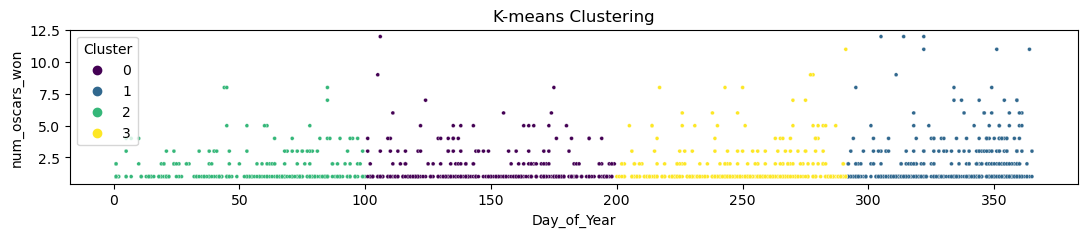

In [44]:
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans

from datetime import datetime

df_time_stamps['Day_of_Year'] = pd.to_datetime(df_time_stamps[['Year', 'Month', 'Day']]).dt.dayofyear

min_value = df_time_stamps['Day_of_Year'].min()
max_value = df_time_stamps['Day_of_Year'].max()
df_time_stamps['Normalized_Day_of_Year'] = (df_time_stamps['Day_of_Year'] - min_value) / (max_value - min_value)

min_value = df_time_stamps['num_oscars_won'].min()
max_value = df_time_stamps['num_oscars_won'].max()
df_time_stamps['Normalized_num_oscars_won'] = (df_time_stamps['num_oscars_won'] - min_value) / (max_value - min_value)

df_time_stamps_withOscar = df_time_stamps[df_time_stamps['num_oscars_won']>0]

num_clusters = 4

kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(df_time_stamps_withOscar[['Normalized_Day_of_Year']])
df_time_stamps_withOscar['Cluster'] = kmeans.labels_

day_clusters = dict()
for i in range(num_clusters):
    day_clusters[i] = [df_time_stamps_withOscar[df_time_stamps_withOscar["Cluster"]==i]["Day_of_Year"].min(), 
                       df_time_stamps_withOscar[df_time_stamps_withOscar["Cluster"]==i]["Day_of_Year"].max()]
    target_date_1 = datetime.strptime(f'2022-{day_clusters[i][0]}', '%Y-%j').strftime('%d-%B')
    target_date_2 = datetime.strptime(f'2022-{day_clusters[i][1]}', '%Y-%j').strftime('%d-%B')
    print(f'Cluster {i}, from {target_date_1} to {target_date_2}')

plt.figure(figsize=(13, 2))
sns.scatterplot(data=df_time_stamps_withOscar, x='Day_of_Year', y='num_oscars_won', hue='Cluster', palette='viridis', s=8)
plt.title('K-means Clustering')
plt.show()


In [49]:
n = 1

first_day, last_day = day_clusters[n][0]-19, day_clusters[n][1]

df_time_stamps['won_oscar'] = (df_time_stamps['num_oscars_won'] > 0).astype(int)
df_time_stamps['time_frame'] = ((df_time_stamps['Day_of_Year'] <= last_day) & (
    df_time_stamps['Day_of_Year'] >= first_day)).astype(int)


matching_vars = ['Year', 'budget'] 


df_matched_treatement, df_matched_control = analyse(df_time_stamps, 'time_frame', matching_vars, 
                                                    'num_oscars_won', 'Wikipedia ID', onehot_vars)

Optimization terminated successfully.
         Current function value: 0.569217
         Iterations 5
1497 4137
Time : 4.050800085067749
Test for num_oscars_won ~ time_frame

                            OLS Regression Results                            
Dep. Variable:         num_oscars_won   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     7.317
Date:                Sun, 10 Dec 2023   Prob (F-statistic):            0.00688
Time:                        12:43:10   Log-Likelihood:                -3242.5
No. Observations:                2435   AIC:                             6489.
Df Residuals:                    2433   BIC:                             6501.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err   

In [50]:
df_matched_treatement, df_matched_control

df_matched_treatement_budget = df_matched_treatement.copy(deep=True).dropna(subset='budget')
df_matched_control_budget = df_matched_control.copy(deep=True).dropna(subset='budget')

print(f'Mean budget of control group : {df_matched_control_budget["budget"].mean()}')
print(f'Mean budget of treatment group : {df_matched_treatement_budget["budget"].mean()}')

Mean budget of control group : 24487173.02138158
Mean budget of treatment group : 25053218.204265792
